In [1]:
from vnstock import Vnstock

Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.3

Phiên bản Vnai 2.0.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnai --upgrade`.
Lịch sử phiên bản: https://pypi.org/project/vnai/#history
Phiên bản hiện tại 2.0.2

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

In [112]:
df = Vnstock().stock(symbol='VPB', source='VCI').quote.history(
            start="2020-05-30",
            end="2025-05-30",
            interval="1D"
        )
df = df[['time', 'high', 'close', 'low', 'volume']]
df = df.set_index('time')
df.shape

(1249, 4)

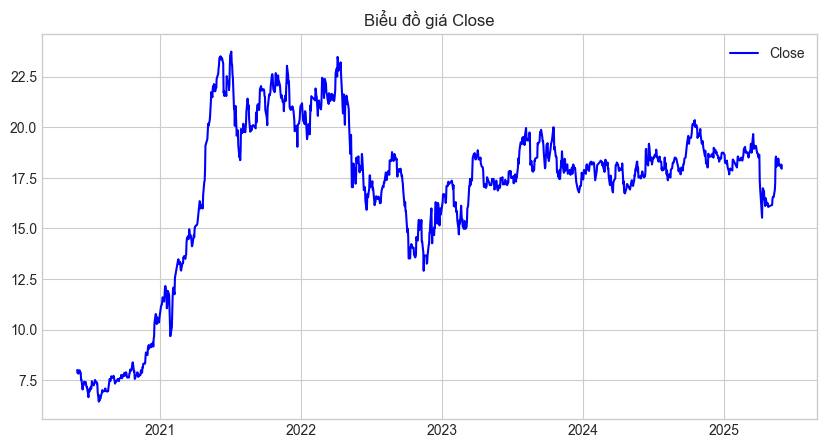

In [114]:
plt.figure(figsize=(10,5))
plt.plot(df['close'], label = 'Close', color = 'blue')
plt.title('Biểu đồ giá Close')
plt.legend()

In [63]:
def cal_metrics(y_true, y_pred):
    # Tính R2
    r2 = r2_score(y_true, y_pred)
    print("R2:", r2) 
    # Tính RMSE
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print("RMSE:", rmse)
    # Tính MAE
    mae = mean_absolute_error(y_true,y_pred)
    print("MAE:", mae)
    mape = mean_absolute_percentage_error(y_true,y_pred)
    print("MAPE:", mape)

def cal_metrics_1by1(y_true, y_pred):
    y_true = np.ravel(y_true) 
    y_pred = np.ravel(y_pred)

    rmse = np.sqrt((y_true - y_pred) ** 2)
    mae = np.abs(y_true - y_pred)
    mape = np.abs((y_true - y_pred) / y_true)

    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })
    return df

def plot_resi(df_metrics):
    df_metrics['phan_du'] = df_metrics['y_pred'] - df_metrics['y_true']
    mean_residual = df_metrics['phan_du'].mean()
    # Thiết lập biểu đồ
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Vẽ histogram bằng Seaborn để có đường cong KDE
    sns.histplot(data=df_metrics, x='phan_du', kde=True, ax=ax, bins=30)
    # Vẽ các đường tham chiếu quan trọng
    ax.axvline(mean_residual, color='green', linestyle=':', linewidth=2, label=f'Phần dư trung bình = {mean_residual:.2f}')

    ax.set_title('Biểu đồ Histogram của Phần dư', fontsize=16)
    ax.set_xlabel('Phần dư (Residuals)')
    ax.set_ylabel('Tần suất')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()

def plot_metrics(df_metrics, metric):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(df_metrics.index, df_metrics[metric], color='green', label='Sai số tuyệt đối hàng ngày')
    mean_error = df_metrics[metric].mean()
    ax.axhline(mean_error, color='red', linestyle='--', label=f'Sai số trung bình = {mean_error:.2f}')
    ax.set_title(f'Biểu đồ Sai số Tuyệt đối {metric} theo Thời gian', fontsize=14)
    ax.set_xlabel('Ngày (Index)')
    ax.set_ylabel('Giá trị Sai số')
    ax.legend()

## Tiền xử lý

In [28]:
feature_columns = ['close', 'high', 'low']

In [29]:
data = df[feature_columns].values
train_data = data[:1100]
test_data = data[1100:]

In [ ]:
# Chuẩn hoá dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(train_data)
sc_test = sc.transform(test_data)

## Train LSTM

In [115]:
features = ['close', 'high', 'low', 'volume']
data = df[features].values
# ----------------------------------------------------

training_data_len = int(np.ceil(len(data) * 0.8))

# Chuẩn hoá dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data = sc.fit_transform(data)

# Tách dữ liệu đã được chuẩn hoá
train_data = scaled_data[0:int(training_data_len), :]

# HÀM TẠO DỮ LIỆU DẠNG CHUỖI THỜI GIAN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(time_step, len(dataset)):
        # Lấy tất cả các feature cho dataX
        dataX.append(dataset[i-time_step:i, :]) # Dùng dấu ':' để lấy tất cả 4 cột
        # Chỉ lấy giá 'close' (cột đầu tiên, index 0) cho dataY
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)
# ---------------------------------------------------

# Đặt độ dài cửa sổ thời gian
time_step = 50
x_train, y_train = create_dataset(train_data, time_step)


# <<< THAY ĐỔI 3: CẬP NHẬT RESHAPE DỮ LIỆU >>>
# Reshape dữ liệu đầu vào cho LSTM [samples, time steps, features]
# Số feature giờ là len(features) (tức là 4), không còn là 1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))
# -------------------------------------------------


# --- 2. XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH ---

model = Sequential()
# <<< THAY ĐỔI 4: CẬP NHẬT INPUT_SHAPE CỦA LSTM >>>
# Cập nhật chiều cuối cùng của input_shape thành len(features)
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], len(features))))
# -------------------------------------------------
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1)) # Đầu ra vẫn là 1 giá trị (giá close)
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks vẫn giữ nguyên
save_model_path = 'best_multivariate_model.keras'
best_model = ModelCheckpoint(save_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Huấn luyện mô hình (không cần thay đổi)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[best_model, early_stop],
                    verbose=1)


# --- 3. DỰ ĐOÁN VÀ ĐÁNH GIÁ TRÊN TẬP TEST ---

# Tải mô hình tốt nhất đã lưu
final_model = load_model(save_model_path)

# Chuẩn bị dữ liệu test (không cần thay đổi)
test_data = scaled_data[training_data_len - time_step:, :]
x_test, y_test_actual = create_dataset(test_data, time_step)

# Reshape dữ liệu test (giống như với x_train)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Dự đoán
y_test_predict = final_model.predict(x_test)


# <<< THAY ĐỔI 5: SỬA LẠI CÁCH INVERSE_TRANSFORM (RẤT QUAN TRỌNG) >>>
# Scaler 'sc' đã học trên 4 feature, nên nó cũng yêu cầu một mảng có 4 feature để inverse.
# Chúng ta cần "dựng" lại một mảng 4 cột để đánh lừa scaler.

# Đối với giá trị dự đoán (y_test_predict)
# 1. Tạo một mảng rỗng có shape (số_lượng_dự_đoán, 4)
predict_extended = np.zeros((len(y_test_predict), len(features)))
# 2. Đặt cột đầu tiên (cột 'close') của mảng này bằng giá trị dự đoán của chúng ta
predict_extended[:, 0] = y_test_predict.flatten()
# 3. Bây giờ mới inverse_transform
y_test_predict = sc.inverse_transform(predict_extended)[:, 0] # Chỉ lấy cột đầu tiên sau khi inverse

# Đối với giá trị thực tế (y_test_actual)
# Làm tương tự
actual_extended = np.zeros((len(y_test_actual), len(features)))
actual_extended[:, 0] = y_test_actual.flatten()
y_test_actual = sc.inverse_transform(actual_extended)[:, 0]
# -------------------------------------------------------------------

Epoch 1/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2059
Epoch 1: val_loss improved from inf to 0.02197, saving model to best_multivariate_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.1883 - val_loss: 0.0220
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0200
Epoch 2: val_loss improved from 0.02197 to 0.00280, saving model to best_multivariate_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0196 - val_loss: 0.0028
Epoch 3/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0081
Epoch 3: val_loss improved from 0.00280 to 0.00191, saving model to best_multivariate_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0082 - val_loss: 0.0019
Epoch 4/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0066
Epoch 4: val_loss improved from 0.00191 to 0.00144, saving model to best_multivariate_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0066 - val_loss: 0.0014
Epoch 5/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/

### Dự đoán cho tập Test

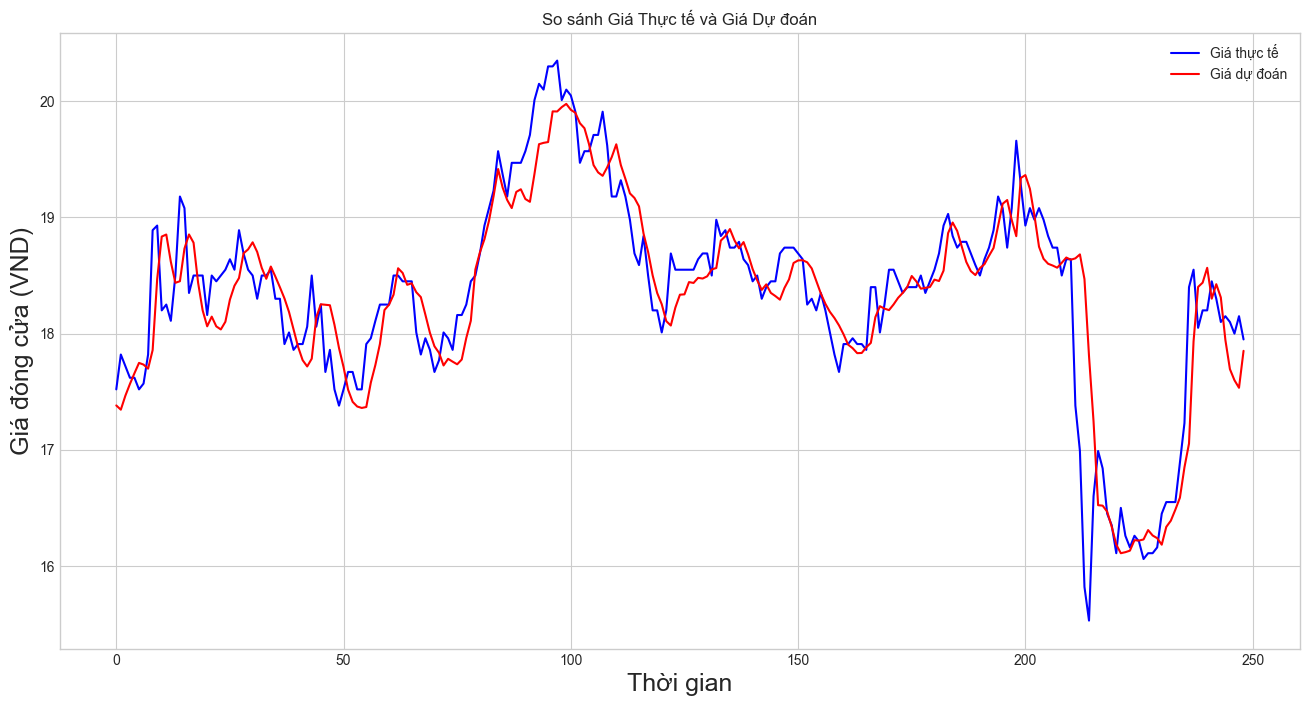

In [116]:
# Tối ưu: Trực quan hoá kết quả
plt.figure(figsize=(16, 8))
plt.title('So sánh Giá Thực tế và Giá Dự đoán')
plt.xlabel('Thời gian', fontsize=18)
plt.ylabel('Giá đóng cửa (VND)', fontsize=18)
plt.plot(y_test_actual, color='blue', label='Giá thực tế')
plt.plot(y_test_predict, color='red', label='Giá dự đoán')
plt.legend()
plt.grid(True)
plt.show()


In [118]:
metrics = cal_metrics_1by1(y_test_actual, y_test_predict)
metrics.tail(10)

,y_true,y_pred,RMSE,MAE,MAPE
239,18.20,18.438440,0.238440,0.238440,0.013101
240,18.20,18.566324,0.366324,0.366324,0.020128
241,18.45,18.300767,0.149233,0.149233,0.008088
242,18.30,18.425252,0.125252,0.125252,0.006844
243,18.10,18.311250,0.211250,0.211250,0.011671
244,18.15,17.946044,0.203956,0.203956,0.011237
245,18.10,17.694350,0.405650,0.405650,0.022412
246,18.00,17.598801,0.401199,0.401199,0.022289
247,18.15,17.533684,0.616316,0.616316,0.033957
248,17.95,17.851786,0.098214,0.098214,0.005472


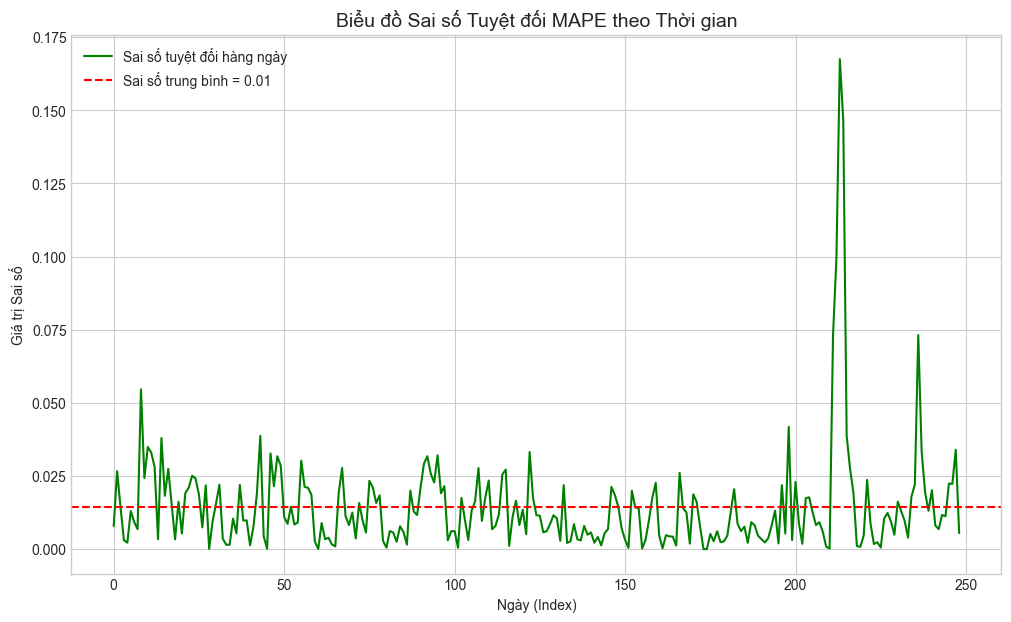

In [119]:
plot_metrics(metrics, 'MAPE')

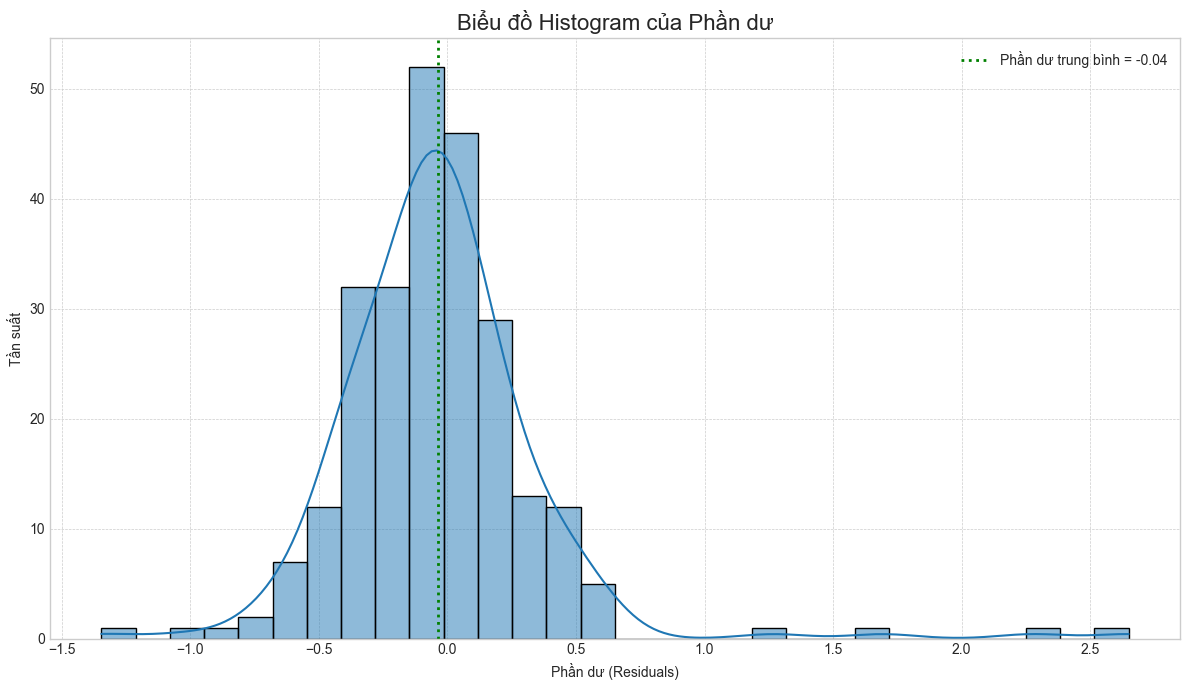

In [120]:
plot_resi(metrics)

In [121]:
cal_metrics(y_test_actual, y_test_predict)

R2: 0.7903694224394546
RMSE: 0.3969355304349154
MAE: 0.25906081142195725
MAPE: 0.014292850899574473


## Train GRU

In [83]:
def create_dataset(dataset, target, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :]) # Lấy tất cả các cột đặc trưng
        y.append(target[i, 0]) # Chỉ dự báo cột 'Close'
    return np.array(X), np.array(y)

num_features = len(feature_columns)
look_back = 60 

X_train, y_train = create_dataset(sc_train, sc_train[:, 0:1], look_back)

# Tạo tập X_test, y_test
inputs = np.concatenate((sc_train[-look_back:], sc_test), axis=0)
X_test, y_test = create_dataset(inputs, inputs[:, 0:1], look_back)

# Dữ liệu đã có dạng 3D [samples, timesteps, features] nên không cần reshape X
print(f"\nHình dạng của X_train: {X_train.shape}")
print(f"Hình dạng của X_test: {X_test.shape}")

# --- Bước 4: Cập nhật Kiến trúc Mô hình GRU ---
print("\nBắt đầu xây dựng mô hình GRU đa biến...")
model = Sequential()

# Cập nhật `input_shape` để phản ánh số lượng đặc trưng mới
model.add(GRU(units=50, return_sequences=True, input_shape=(look_back, num_features)))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# --- Bước 5: Huấn luyện mô hình (Không thay đổi) ---
print("\nBắt đầu huấn luyện mô hình đa biến...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
print("Huấn luyện hoàn tất.")

# --- Bước 6: Dự báo và Đánh giá (Cần điều chỉnh bước inverse_transform) ---
print("\nThực hiện dự báo trên tập test...")
forecast_gru = model.predict(X_test)
dummy_array = np.zeros((len(forecast_gru), num_features))
dummy_array[:, 0] = forecast_gru.flatten() # Đặt cột dự báo vào vị trí đầu tiên ('Close')

# Bây giờ mới thực hiện biến đổi ngược
forecast_gru = sc.inverse_transform(dummy_array)[:, 0] # Lấy lại cột giá đã biến đổi ngược


Hình dạng của X_train: (1040, 60, 3)
Hình dạng của X_test: (149, 60, 3)

Bắt đầu xây dựng mô hình GRU đa biến...

Bắt đầu huấn luyện mô hình đa biến...


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Huấn luyện hoàn tất.

Thực hiện dự báo trên tập test...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


In [84]:
actual_price = test_data[:, 0]

In [73]:
actual_price.shape

(149,)

In [58]:
forecast_gru.shape

(149,)

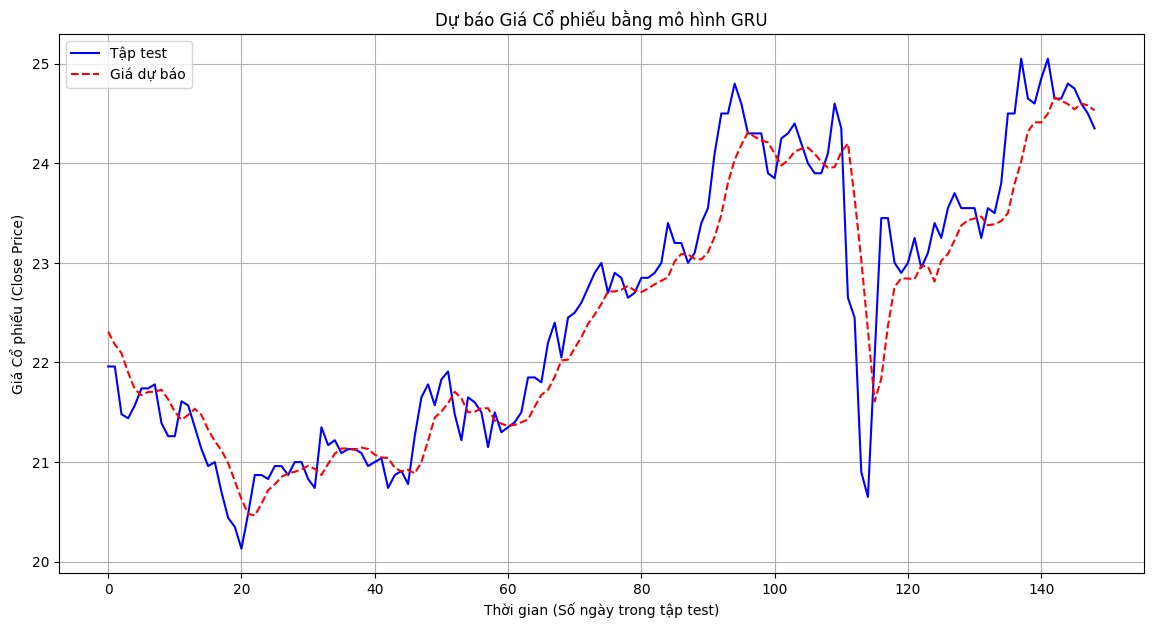

In [85]:
# --- Bước 6: Trực quan hóa kết quả ---
plt.figure(figsize=(14, 7))
plt.plot(actual_price, color='blue', label='Tập test')
plt.plot(forecast_gru, color='red', linestyle='--', label='Giá dự báo')
plt.title('Dự báo Giá Cổ phiếu bằng mô hình GRU')
plt.xlabel('Thời gian (Số ngày trong tập test)')
plt.ylabel('Giá Cổ phiếu (Close Price)')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
cal_metrics(actual_price, forecast_gru)

R2: 0.8862923568379845
RMSE: 0.4568982895303778
MAE: 0.3088402866357123
MAPE: 0.013680039404507717


In [87]:
metrics = cal_metrics_1by1(actual_price, forecast_gru)

## Train Hybrid ARIMA - LSTM

In [122]:
import warnings

warnings.filterwarnings('ignore')
data_series = df['close']

# Phân chia train/test
split_point = int(len(data_series) * 0.9)
train_data = data_series.iloc[:split_point]
test_data = data_series.iloc[split_point:]

print(f"Kích thước tập Train: {len(train_data)}")
print(f"Kích thước tập Test: {len(test_data)}")

# Siêu tham số
N_LAGS = 50 # LSTM thường hưởng lợi từ chuỗi dài hơn
WINDOW_SIZE = 5

# --- BƯỚC 1.1: CHUẨN HÓA DỮ LIỆU (QUAN TRỌNG CHO LSTM) ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Hàm tạo dataset cho LSTM (yêu cầu input 3D)
def create_lstm_dataset(data, n_lags):
    X, y = [], []
    for i in range(len(data) - n_lags):
        X.append(data[i:(i + n_lags), 0])
        y.append(data[i + n_lags, 0])
    X, y = np.array(X), np.array(y)
    # Reshape X để có dạng 3D [samples, timesteps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

# --- BƯỚC 1.2: HUẤN LUYỆN MÔ HÌNH LSTM MỘT LẦN DUY NHẤT ---
X_train_lstm, y_train_lstm = create_lstm_dataset(scaled_train_data, N_LAGS)

# Xây dựng mô hình LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- Bắt đầu huấn luyện mô hình LSTM ---")
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)
print("--- Huấn luyện LSTM hoàn tất ---")


# Tính toán các sai số của LSTM trên tập train để làm mồi
lstm_preds_insample_scaled = lstm_model.predict(X_train_lstm)
lstm_preds_insample_unscaled = scaler.inverse_transform(lstm_preds_insample_scaled)
y_train_unscaled = scaler.inverse_transform(y_train_lstm.reshape(-1, 1))
lstm_train_errors = list(y_train_unscaled.flatten() - lstm_preds_insample_unscaled.flatten())

# --- BƯỚC 2: "Cold Start" - Tính toán trọng số ban đầu ---
print("\n--- Tính toán trọng số ban đầu trên tập train ---")
arima_model_initial = pm.auto_arima(train_data, seasonal=False, suppress_warnings=True, stepwise=True)
arima_preds_on_train = arima_model_initial.predict_in_sample()

# Lấy các dự báo cuối cùng từ LSTM (đã được unscale ở trên)
lstm_preds_on_train_unscaled = lstm_preds_insample_unscaled

# Tính MAPE trên WINDOW_SIZE điểm cuối của tập train
true_values_window = train_data.iloc[-WINDOW_SIZE:]
arima_mape_initial = mean_absolute_percentage_error(true_values_window, arima_preds_on_train[-WINDOW_SIZE:])
lstm_mape_initial = mean_absolute_percentage_error(
    train_data.iloc[N_LAGS:][-WINDOW_SIZE:], # Cần khớp chỉ số với y_train
    lstm_preds_on_train_unscaled[-WINDOW_SIZE:]
)

print(f'ARIMA initial MAPE: {arima_mape_initial:.4f}')
print(f'LSTM initial MAPE: {lstm_mape_initial:.4f}')

total_mape_initial = lstm_mape_initial + arima_mape_initial + 1e-9 # Thêm epsilon để tránh chia cho 0
lstm_weight = arima_mape_initial / total_mape_initial
arima_weight = 1 - lstm_weight
print(f"Trọng số ban đầu: LSTM={lstm_weight:.2f}, ARIMA={arima_weight:.2f}")

# --- BƯỚC 3: Vòng lặp Dự báo với Trọng số Động ---
print(f"\n--- Bắt đầu dự báo với trọng số động trên cửa sổ {WINDOW_SIZE} điểm gần nhất ---")
history = list(train_data)
hybrid_predictions = []

for t in range(len(test_data)):
    current_date = test_data.index[t].date()
    
    # 3.1: Dự báo 1 bước cho thời điểm t
    # ARIMA
    arima_model_step = pm.auto_arima(pd.Series(history, index=df.index[:len(history)]), seasonal=False, suppress_warnings=True, stepwise=True)
    arima_pred = arima_model_step.predict(n_periods=1).iloc[0]

    # LSTM
    # Lấy N_LAGS điểm cuối từ history, chuẩn hóa, reshape và dự báo
    input_sequence_unscaled = np.array(history[-N_LAGS:]).reshape(-1, 1)
    input_sequence_scaled = scaler.transform(input_sequence_unscaled)
    input_lstm = input_sequence_scaled.reshape(1, N_LAGS, 1)
    
    lstm_pred_scaled = lstm_model.predict(input_lstm, verbose=0)
    # BIẾN ĐỔI NGƯỢC về thang đo giá gốc
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)[0, 0]

    # 3.2: Tính dự báo hybrid có trọng số
    weighted_pred = arima_weight * arima_pred + lstm_weight * lstm_pred

    # 3.3: Tính thành phần hiệu chỉnh sai số
    error_correction = np.mean(lstm_train_errors[-3:]) if len(lstm_train_errors) >= 3 else 0

    # 3.4: Tính dự báo cuối cùng
    final_pred = weighted_pred - error_correction
    hybrid_predictions.append(final_pred)

    # 3.5: Cập nhật lịch sử và sai số
    actual_value = test_data.iloc[t]
    history.append(actual_value)
    new_lstm_error = actual_value - lstm_pred
    lstm_train_errors.append(new_lstm_error)

    # 3.6: CẬP NHẬT TRỌNG SỐ CHO BƯỚC TIẾP THEO DỰA TRÊN CỬA SỔ
    # Cần tạo lại X, y trên toàn bộ history để đánh giá
    scaled_history = scaler.transform(np.array(history).reshape(-1, 1))
    X_hist_lstm, y_hist_lstm_scaled = create_lstm_dataset(scaled_history, N_LAGS)
    
    # Lấy giá trị thực trong cửa sổ (ở thang đo gốc)
    true_window = np.array(history[-WINDOW_SIZE:])
    
    # Lấy dự báo của ARIMA trong cửa sổ
    arima_preds_in_history = arima_model_step.predict_in_sample()
    arima_pred_window = arima_preds_in_history[-WINDOW_SIZE:]
    
    # Lấy dự báo của LSTM trong cửa sổ
    lstm_preds_in_history_scaled = lstm_model.predict(X_hist_lstm, verbose=0)
    lstm_preds_in_history_unscaled = scaler.inverse_transform(lstm_preds_in_history_scaled)
    lstm_pred_window = lstm_preds_in_history_unscaled[-WINDOW_SIZE:].flatten()
    
    # Tính MAPE mới
    arima_mape_new = mean_absolute_percentage_error(true_window, arima_pred_window)
    lstm_mape_new = mean_absolute_percentage_error(true_window, lstm_pred_window)

    # Cập nhật trọng số
    total_mape_new = lstm_mape_new + arima_mape_new + 1e-9
    lstm_weight = arima_mape_new / total_mape_new
    arima_weight = 1 - lstm_weight
    
    print(f"Ngày {current_date}: Dự báo={final_pred:.2f}, Thực tế={actual_value:.2f} -> Trọng số LSTM cho ngày mai={lstm_weight:.2f}")

Kích thước tập Train: 1124
Kích thước tập Test: 125

--- Bắt đầu huấn luyện mô hình LSTM ---
--- Huấn luyện LSTM hoàn tất ---
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

--- Tính toán trọng số ban đầu trên tập train ---
ARIMA initial MAPE: 0.0110
LSTM initial MAPE: 0.0174
Trọng số ban đầu: LSTM=0.39, ARIMA=0.61

--- Bắt đầu dự báo với trọng số động trên cửa sổ 5 điểm gần nhất ---
Ngày 2024-11-25: Dự báo=17.96, Thực tế=18.55 -> Trọng số LSTM cho ngày mai=0.43
Ngày 2024-11-26: Dự báo=17.99, Thực tế=18.55 -> Trọng số LSTM cho ngày mai=0.38
Ngày 2024-11-27: Dự báo=18.22, Thực tế=18.55 -> Trọng số LSTM cho ngày mai=0.40
Ngày 2024-11-28: Dự báo=18.32, Thực tế=18.55 -> Trọng số LSTM cho ngày mai=0.31
Ngày 2024-11-29: Dự báo=18.36, Thực tế=18.64 -> Trọng số LSTM cho ngày mai=0.20
Ngày 2024-12-02: Dự báo=18.41, Thực tế=18.69 -> Trọng số LSTM cho ngày mai=0.19
Ngày 2024-12-03: Dự báo=18.39, Thực tế=18.69 -> Trọng số LSTM cho ngày mai=0.19
Ngày 2024-12-04: Dự báo=18.34, Thực tế=18.50 -> Trọng số LST

<Axes: title={'center': 'So sánh giá trị Thực tế và Dự báo Hybrid (ARIMA + LSTM)'}, xlabel='time'>

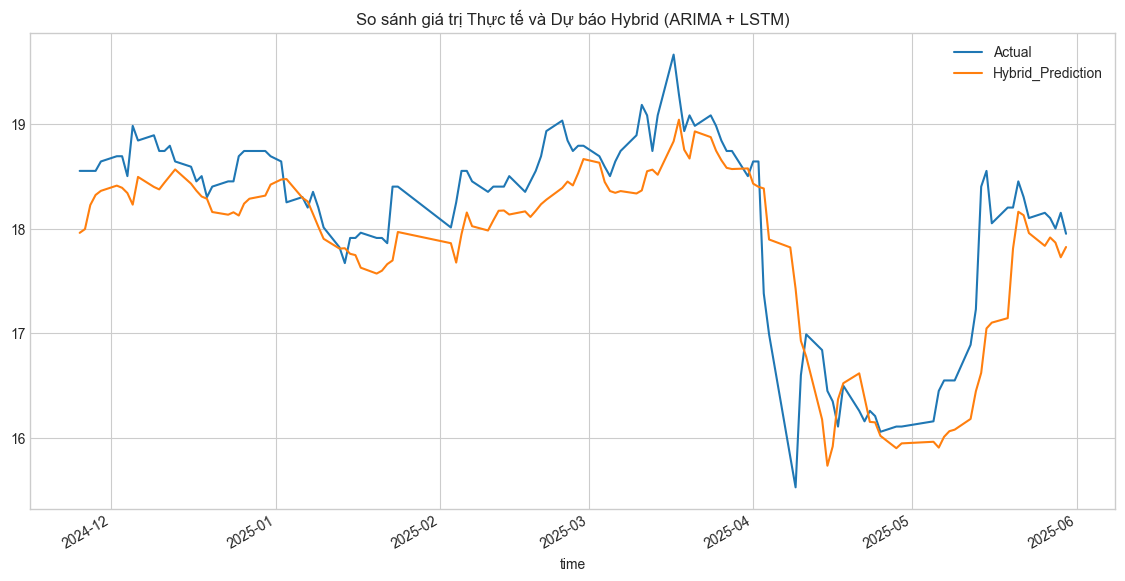

In [123]:
# Trực quan hóa kết quả
results_df = pd.DataFrame({
    'Actual': test_data,
    'Hybrid_Prediction': hybrid_predictions
}, index=test_data.index)

results_df.plot(figsize=(14, 7), title='So sánh giá trị Thực tế và Dự báo Hybrid (ARIMA + LSTM)')

In [124]:
cal_metrics(test_data, hybrid_predictions)

R2: 0.6857431686206026
RMSE: 0.5110184699865077
MAE: 0.38194968843794386
MAPE: 0.02132452826389196


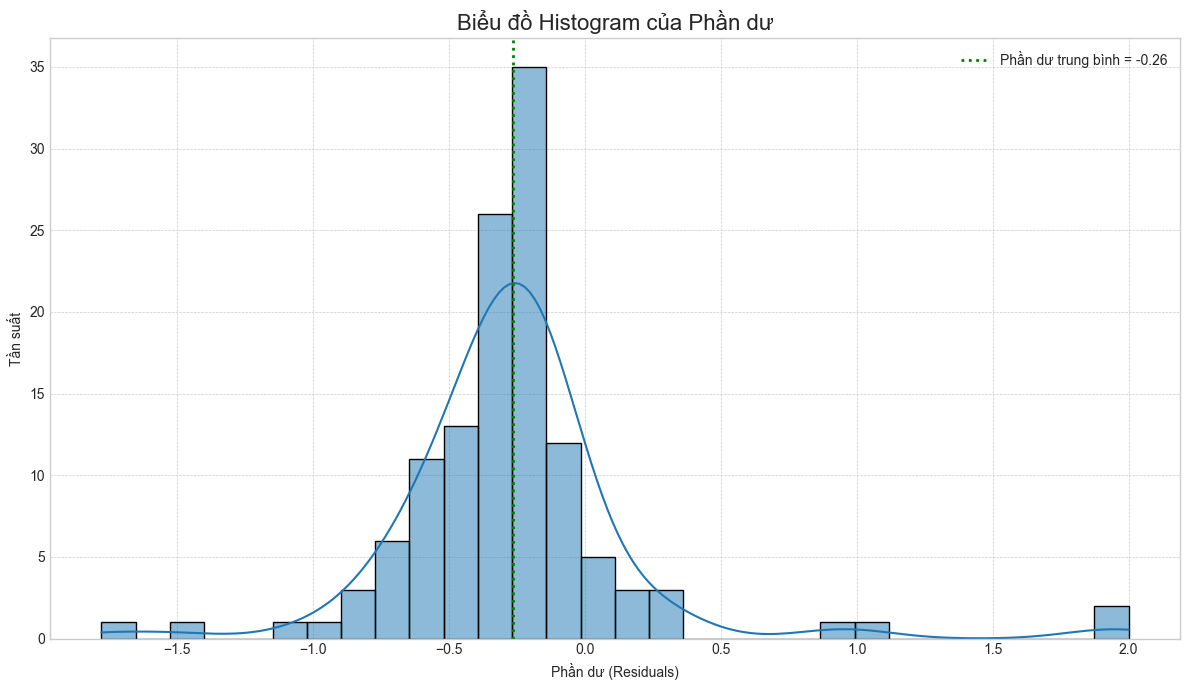

In [125]:
metrics = cal_metrics_1by1(test_data, hybrid_predictions)
plot_resi(metrics)